

# Relation Network for Meta-Learning with training and  testing conducted on Omniglot dataset

This implementation is the work referenced from [Learning to Compare](https://arxiv.org/abs/1711.06025), which proposes two different architectures  (Few Shot Classification vs Zero Shot Classification) but in this work one shot 20 way classification for omniglot data set has been used.

## Downloading Dataset and Setting up Folder Space

Note : The commands below are needed as this Notebook was run on google colab. 

(else run the following three blocks on command prompt without ""!"" mark before the commands )

Downloading the Omniglot dataset.


In [0]:
!ls
!rm -rf images_background 
!rm -rf images_evaluation
!rm -rf omniglot
!rm -rf sample_data
!ls

images_background  model_f.h5	 model.h5    omniglot
images_evaluation  model_f.json  model.json  validation_result.pickle
model_f.h5  model_f.json  model.h5  model.json	validation_result.pickle


In [0]:
!git clone https://github.com/brendenlake/omniglot.git
!ls omniglot/python

Cloning into 'omniglot'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 78
Unpacking objects: 100% (81/81), done.
demo.py			      one-shot-classification
images_background_small1.zip  strokes_background_small1.zip
images_background_small2.zip  strokes_background_small2.zip
images_background.zip	      strokes_background.zip
images_evaluation.zip	      strokes_evaluation.zip


Unzip the  tranining and evaluation files.

Make sure the current folder contains images_background,  images_evaluation and   omniglot, when  the output is printed out.

In [0]:
from zipfile import ZipFile 
with ZipFile('omniglot/python/images_background.zip', 'r') as zpObjt:
     zpObjt.extractall()

with ZipFile('omniglot/python/images_evaluation.zip','r') as zpobje:
     zpobje.extractall()

a=!ls
print('The current contents of folder')
print(a)

The current contents of folder
['images_background  model_f.h5\t model.h5    omniglot', 'images_evaluation  model_f.json  model.json  validation_result.pickle']


## Extracting data to variables
Creating list of training and testing classes.

In [0]:
# Uncomment the below commands if 
#!rm -rf images_evaluation/val.pickle
#!rm -rf images_background/train.pickle
#!rm -rf images_background/train_original.pickle

import os

train_folders=os.listdir('images_background')
n_classes_train=len(train_folders)
print("Number of alphabets in Training folder : %d" %n_classes_train)

test_folders=os.listdir('images_evaluation')
n_classes_test=len(test_folders)
print("\nNumber of alphabets in Evaluation folder : %d" %n_classes_test)


Number of alphabets in Training folder : 30

Number of alphabets in Evaluation folder : 20


## Data Augmentation, Serializing data and storing the objects into character stream for easy access

As indicated in  [Learning to Compare](https://arxiv.org/abs/1711.06025), there are additional classes were created by rotating some training and testing data by (90,180,270). 
In the block below training data has been rotataed and appendedwith the original training data.
images_evaluation folder of omniglot contains enough classes about  600 to 650 classes which deemed sufficient for this work while during training additional data is needed for validation purpose, hence additional 255 classes were augmented to training dataset.
Also for easy access and serialization of the data into byte streams.

Note: Both training and testing data has been resized to (28,28) from (105,105). Initially 105,105 was used not only did it increase the number of parameters in the Relational Network (which is obvious) but it takes a longer time to converge on optimization during training.

In [0]:
import numpy as np
from imageio import imread
import pickle
import math 
import cv2
import imutils


train_catalogue={}
test_catalogue={}
# key is the name of the alphabet and value is the tuple of 2 objects 1:list of letters/characters 2:list of number of examples for each character 
# list of number of character initially assigned to None

X=[]
index=0
for alphabet in train_folders:
  temp_chars=os.listdir('images_background/'+alphabet)
  Y=[]
  for char in temp_chars:
    start=index
    temp_image_stack=[]
    for image_name in os.listdir('images_background/'+alphabet+'/'+char):
      image=imread('images_background/'+alphabet+'/'+char+'/'+image_name)
      image = cv2.resize(image, (28, 28)) 
      temp_image_stack.append(image)    
    X.append(temp_image_stack)
  index+=len(os.listdir('images_background/'+alphabet))
  temp_marker=(start,index-1)
  Y.append(temp_marker)
  train_catalogue[alphabet]=(temp_chars,Y)
train_original_catalogue=train_catalogue
Z=np.stack(X)
print('Original Train data set shape:')
print(Z.shape)
with open('images_background/train_original.pickle', "wb") as f:
               pickle.dump((Z,train_original_catalogue),f)

rotate_bys=[90,180,270]
for rb in rotate_bys:
  ran_alphabets=np.random.choice(train_folders,15,replace=False)
  for alphabet in ran_alphabets:
    temp_chars=os.listdir('images_background/'+alphabet)
    temp_chars=np.random.choice(temp_chars,5,replace=False)
    Y=[]
    for char in temp_chars:
      start=index
      temp_image_stack=[]
      for image_name in os.listdir('images_background/'+alphabet+'/'+char):
        image=imread('images_background/'+alphabet+'/'+char+'/'+image_name)
        image = cv2.resize(image, (28, 28)) 
        image = imutils.rotate(image, rb)
        temp_image_stack.append(image)    
      X.append(temp_image_stack)
    index+=len(os.listdir('images_background/'+alphabet))
    temp_marker=(start,index-1)
    Y.append(temp_marker)
    train_catalogue[alphabet+'rotate_by_'+str(rb)]=(temp_chars,Y)
  
X = np.stack(X)
print('Augmented Train data set shape:')
print(X.shape)

with open('images_background/train.pickle', "wb") as f:
               pickle.dump((X,train_catalogue),f)
  
X=[]
index=0
for alphabet in test_folders:
  temp_chars=os.listdir('images_evaluation/'+alphabet)
  Y=[]
  for char in temp_chars:
    start=index
    temp_image_stack=[]
    for image_name in os.listdir('images_evaluation/'+alphabet+'/'+char):
      image=imread('images_evaluation/'+alphabet+'/'+char+'/'+image_name)
      image = cv2.resize(image, (28, 28)) 
      temp_image_stack.append(image)
    X.append(temp_image_stack)
  index+=len(os.listdir('images_evaluation/'+alphabet))
  temp_marker=(start,index-1)
  Y.append(temp_marker)
  test_catalogue[alphabet]=(temp_chars,Y)
X = np.stack(X)

print('Original Test data set shape:')
print(X.shape)

with open('images_evaluation/val.pickle', "wb") as f:
               pickle.dump((X,test_catalogue),f)

Original Train data set shape:
(964, 20, 28, 28)
Augmented Train data set shape:
(1189, 20, 28, 28)
Original Test data set shape:
(659, 20, 28, 28)


## Information about data set and  Visualizing sample data from training and testing set

An insight into the original training (non- augmented) and testing data set is provided in the next three blocks.

##### Training Data Set
It looks like Tifinagh, Gujarati and Japanese alphabets are contributing more characters to the data set and hence more number of classes for training. In terms of percentage contribution Tifinagh is contributing about 5.7% while Japanese seems to be contributing 5.4% and Gujarati contributing about 5% to a total of 964 classes in the original dataset. Ojibwe seems to be contributing the least to the classes.

##### Testing Data Set
On the other hand the testing data set all the alphabets seem to be contributing equally with few exceptions like Galgothic, Malayalam, oriya. The variance in terms of contribution to the classes by each alphabet is less when compared to training dataset.

Though there are differences in terms of contributions by individual alphabet, the uniform nature has been maintained in terms of number examples for each class contributes (20 examples per class).

Total number of classes in training 964
Total number of classes in testing 659


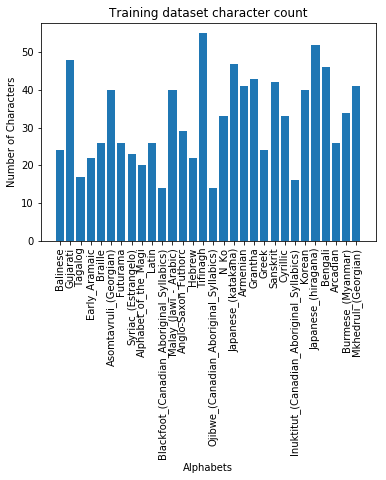

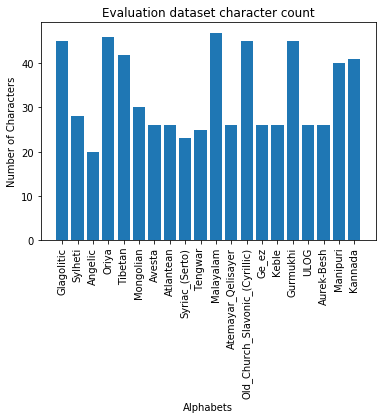

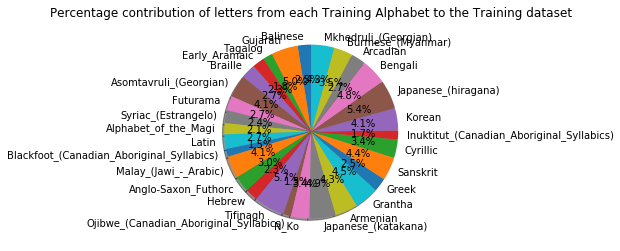

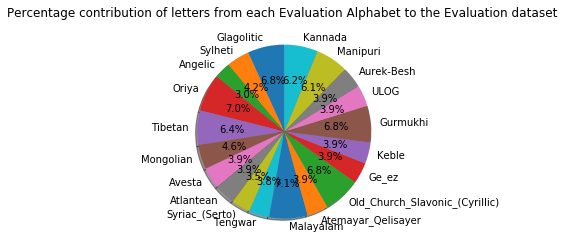

In [0]:
# Load the pickled data
with open('images_background/train_original.pickle',"rb") as f:
  (train_data,train_catalogue)=pickle.load(f)
with open('images_evaluation/val.pickle',"rb") as f:
  (eval_data,eval_catalogue)=pickle.load(f)
  


train_char_stats={}
for alphabet in train_catalogue.keys():
  train_char_stats[alphabet]=len(train_catalogue[alphabet][0])

total_train_classes=np.sum(np.array(list(train_char_stats.values())))

print('Total number of classes in training '+str(total_train_classes))

percentage_train_contribution=np.array(list(train_char_stats.values()))/total_train_classes
percentage_train_contribution*=100
test_char_stats={}

for alphabet in eval_catalogue.keys():
  test_char_stats[alphabet]=len(eval_catalogue[alphabet][0])


total_test_classes=np.sum(np.array(list(test_char_stats.values())))

print('Total number of classes in testing '+str(total_test_classes))

percentage_test_contribution=np.array(list(test_char_stats.values()))/total_test_classes
percentage_test_contribution*=100
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
rects=ax.bar(np.arange(len(train_char_stats.keys())),train_char_stats.values(), align = 'center')
ax.set_xticks(np.arange(len(train_char_stats.keys())))
ax.set_xticklabels(train_char_stats.keys(), rotation=90)
ax.set_ylabel('Number of Characters')
ax.set_xlabel('Alphabets')
ax.set_title('Training dataset character count')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
rects=ax.bar(np.arange(len(test_char_stats.keys())),test_char_stats.values(), align = 'center')
ax.set_xticks(np.arange(len(test_char_stats.keys())))
ax.set_xticklabels(test_char_stats.keys(), rotation=90)
ax.set_ylabel('Number of Characters')
ax.set_xlabel('Alphabets')
ax.set_title('Evaluation dataset character count')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
circs=ax.pie(percentage_train_contribution, labels=list(train_char_stats.keys()), autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Percentage contribution of letters from each Training Alphabet to the Training dataset')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
circs=ax.pie(percentage_test_contribution, labels=list(test_char_stats.keys()), autopct='%1.1f%%',
        shadow=True, startangle=90)
#ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percentage contribution of letters from each Evaluation Alphabet to the Evaluation dataset ')
plt.show()



  

#### Run this Block only if you need to know the data labels and related information which can be used for displaying images

In [0]:
print('List of Alaphabets in training class\(Use it for displaying image\): ')

for alphabet in train_catalogue.keys():
  print("Alphabet : " + alphabet + " has  " + str(train_char_stats[alphabet]) + " characters")
  
print('\nList of Alaphabets in testing/evaluation class\(Use it for displaying image\): ')

for alphabet in eval_catalogue.keys():
  print("Alphabet : " + alphabet + " has  " + str(test_char_stats[alphabet]) + " characters")

List of Alaphabets in training class\(Use it for displaying image\): 
Alphabet : Balinese has  24 characters
Alphabet : Gujarati has  48 characters
Alphabet : Tagalog has  17 characters
Alphabet : Early_Aramaic has  22 characters
Alphabet : Braille has  26 characters
Alphabet : Asomtavruli_(Georgian) has  40 characters
Alphabet : Futurama has  26 characters
Alphabet : Syriac_(Estrangelo) has  23 characters
Alphabet : Alphabet_of_the_Magi has  20 characters
Alphabet : Latin has  26 characters
Alphabet : Blackfoot_(Canadian_Aboriginal_Syllabics) has  14 characters
Alphabet : Malay_(Jawi_-_Arabic) has  40 characters
Alphabet : Anglo-Saxon_Futhorc has  29 characters
Alphabet : Hebrew has  22 characters
Alphabet : Tifinagh has  55 characters
Alphabet : Ojibwe_(Canadian_Aboriginal_Syllabics) has  14 characters
Alphabet : N_Ko has  33 characters
Alphabet : Japanese_(katakana) has  47 characters
Alphabet : Armenian has  41 characters
Alphabet : Grantha has  43 characters
Alphabet : Greek has  

 ## Images of alphabets
 Here all the characters from an alphabet can be visualizaed to understand the nature of data for both training and testing data.
 
 As an example , the code block from below showcases all the characters from "Kannada" alphabet available in the training dataset

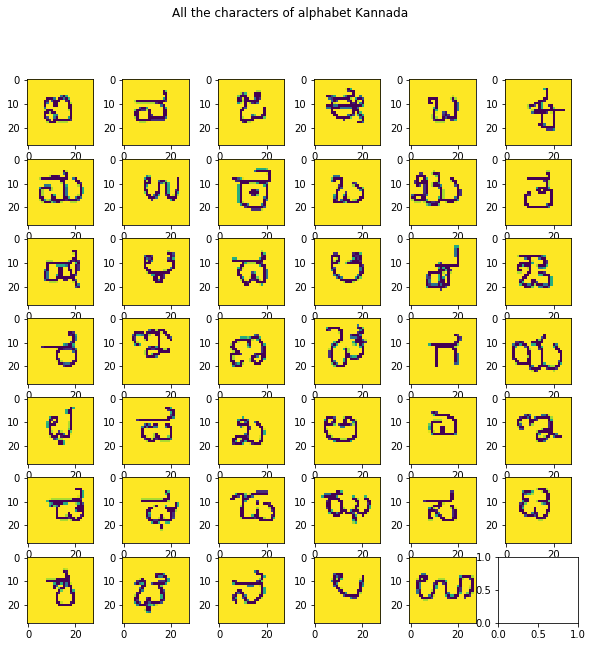

In [0]:
import imutils
import math

def plot_image(data_set="train",alphabet="Gujarati"):
  image=None
  image_list=[]
  rows=0
  if data_set=="train" :
    characters=train_catalogue[alphabet]
    rows=math.ceil(len(characters[0])/6)
    for i in range(characters[1][0][0],characters[1][0][1]+1):
      image_list.append(train_data[i,0])
  elif data_set=="test" :
    characters=eval_catalogue[alphabet]
    rows=math.ceil(len(characters[0])/6)
    for i in range(characters[1][0][0],characters[1][0][1]+1):
      image_list.append(eval_data[i,0])
  else:
    print('not available')
    
  f, axarr = plt.subplots(rows,6, figsize=(10,10))
  for i in range(rows):
        for j in range(6):
            if len(image_list)!=0:
                axarr[i,j].imshow(image_list.pop(),)
  f.suptitle('All the characters of alphabet '+ alphabet)
  f.show()

plot_image("test","Kannada")

## Model Architecture
*As the title of this notebook indicates Relation Network has been used for this work*

**Architecture Selection:**   For Meta Learning the features of the reference and the query are compared to obtain a single value called score. This can be accomplished in many ways. A direct distance metric with flattened image vectors as reference and query image can be used but to get better scores the reference image as feature vector must be robust but with one shot classification it is hard for just one image to be robust enough to represent handwritings of various people. A solution to this can be found in Saimese network where an encoder based neural network is used to extract features and a distance metric is used to get comparison score. 

*Relation Network(One shot) :* The encoder  network first extracts features from reference image and query image the features are concatenated and deep relation network is used to extract deep distance metric as a score. Since further analysis on the similarites in the features is carried by the relation network on the features 

**Architecture:** The architecture details and the differentiation between one shot and few shot is presented in the image below with information obtained from [Learning to Compare](https://arxiv.org/abs/1711.06025)
**Optimization** Adam Optimizer with a learning rate of 0.00005 and with binary cross entropy as the optimization loss function on the final output of the network i.e. Comparison score.
(As noted in the paper even MSE can be used as the optimization loss function.)

Relation Network Architecture
<img src="https://drive.google.com/uc?export=view&id=1cjrgt2JbY1eJzTOvoWBESJHeqixpwk9P">

In [0]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import math
from sklearn.utils import shuffle
from keras.layers import Input, Conv2D ,Lambda, merge, Dense, Flatten,MaxPooling2D,BatchNormalization,Activation,Concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.losses import mean_squared_error

In [0]:
Left_input=Input((28,28,1))
Right_input=Input((28,28,1))


encoder_net=Sequential()
encoder_net.add(Lambda(lambda x:x/255.,input_shape=(28,28,1)))
encoder_net.add(Conv2D(64,(3,3),padding='same',kernel_initializer='random_normal',bias_initializer='random_uniform'))
encoder_net.add(BatchNormalization())
encoder_net.add(Activation('relu'))

encoder_net.add(MaxPooling2D())

encoder_net.add(Conv2D(64,(3,3),padding='same',kernel_initializer='random_normal',bias_initializer='random_uniform'))
encoder_net.add(BatchNormalization())
encoder_net.add(Activation('relu'))

encoder_net.add(MaxPooling2D())

encoder_net.add(Conv2D(64,(3,3),padding='same',kernel_initializer='random_normal',bias_initializer='random_uniform'))
encoder_net.add(BatchNormalization())
encoder_net.add(Activation('relu'))

encoder_net.add(Conv2D(64,(3,3),padding='same',kernel_initializer='random_normal',bias_initializer='random_uniform'))
encoder_net.add(BatchNormalization())
encoder_net.add(Activation('relu'))


reference_leg = encoder_net(Left_input)
test_leg= encoder_net(Right_input)




Concat_layer=Lambda(lambda tensors:K.concatenate([tensors[0] , tensors[1]],axis=2))

r_net_input=Concat_layer([reference_leg, test_leg])

r_net_layer1=Conv2D(64,(3,3),padding='same',kernel_initializer='random_normal',bias_initializer='random_uniform')(r_net_input)
r_net_layer1=BatchNormalization()(r_net_layer1)
r_net_layer1=Activation('relu')(r_net_layer1)

r_net_layer1=MaxPooling2D()(r_net_layer1)

r_net_layer2=Conv2D(64,(3,3),padding='same',kernel_initializer='random_normal',bias_initializer='random_uniform')(r_net_layer1)
r_net_layer2=BatchNormalization()(r_net_layer2)
r_net_layer2=Activation('relu')(r_net_layer2)

r_net_layer2=MaxPooling2D()(r_net_layer2)

r_net_layer3=Flatten()(r_net_layer2)

r_net_layer3=Dense(8,activation="relu",kernel_initializer='random_normal',bias_initializer='random_uniform')(r_net_layer3)

comparison_result=Dense(1,activation="sigmoid",kernel_initializer='random_normal',bias_initializer='random_uniform')(r_net_layer3)

relational_net=Model(inputs=[Left_input,Right_input],outputs=comparison_result)
optimizer=Adam(0.00005) #learning rate set to 0.001, beta1& beta2 of MA left to default
relational_net.compile(loss="binary_crossentropy",optimizer=optimizer)
relational_net.summary()
relational_net.count_params()

W0629 02:48:55.458606 139784409974656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0629 02:48:55.468108 139784409974656 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 7, 7, 64)     112448      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 7, 14, 64)    0           sequential_1[1][0]               
          

188369

## Creating Data Loader for Training and Evaluation

1.  Training data has been split into Training and Validation set with 80% to 20% ratio split respectively.
2.  A function to create batch of paired data with labels for training is included.
3.  Validation and Testing functions are done as episodes where each episode goes through all the classes in the validation and testing data set once completely.
4. A separate function to test accuracy for each class has been created.   

In [0]:
class data_loader:
  def __init__(self):
    self.data={}
    self.data_details={}
    with open('images_background/train.pickle',"rb") as f:
      (temp_train,train_catalogue)=pickle.load(f)
    with open('images_evaluation/val.pickle',"rb") as f:
      (self.data["eval"],eval_catalogue)=pickle.load(f)
    
    np.random.shuffle(temp_train)
    train_number=(temp_train.shape[0]*80)//100
    self.data["train"]=temp_train[:train_number,:,:,:]
    self.data["val"]=temp_train[train_number:,:,:,:]
    
    self.previous_batch_true_class=0
      
    (tnc,tne,tw,th)=self.data["train"].shape
    self.data_details["train"]=(tnc,tne,tw,th)
    (tnc,tne,tw,th)=self.data["val"].shape
    self.data_details["val"]=(tnc,tne,tw,th)
    (tnc,tne,tw,th)=self.data["eval"].shape
    self.data_details["eval"]=(tnc,tne,tw,th)
    
  def one_shot_Nway_task(self, N_way,i,ds_name="eval"):
    #select N way random classes and set the first one as actual class  

    N_random_class = np.random.choice(self.data_details[ds_name][0],size=(N_way,),replace=False)
    in_examples = np.random.randint(0,self.data_details[ds_name][1],size=(N_way,))
    actual_class = i
    
    exmpls= np.random.choice(self.data_details[ds_name][1],size=(2,),replace=False)
    test_image = np.asarray([self.data[ds_name][actual_class,exmpls[0],:,:]]*N_way).reshape(N_way,self.data_details[ds_name][2],self.data_details[ds_name][3],1)
    Nw_ref_set = self.data[ds_name][N_random_class,in_examples,:,:]
    Nw_ref_set[0,:,:] = self.data[ds_name][actual_class,exmpls[1]] #reassigning first example
    Nw_ref_set = Nw_ref_set.reshape(N_way,self.data_details[ds_name][2],self.data_details[ds_name][3],1)
    inputs = [test_image,Nw_ref_set]
    class_labels = np.zeros((N_way,))
    class_labels[0] = 1
    return inputs,class_labels
    
  
  def batch_data(self,batch_size,ds_name="train"):
    
    random_class=np.random.choice(self.data_details[ds_name][0],size=(batch_size,),replace=False)
    inputs=[np.zeros((batch_size, self.data_details[ds_name][3],  self.data_details[ds_name][2],1)) for i in range(2)]
    class_labels=np.zeros((batch_size,))
    pos_class_ind=math.floor(batch_size/2)
    class_labels[:pos_class_ind]=1
    
    for sel_class,i in zip(random_class,range(batch_size)):
      in1=sel_class
      in2=sel_class
      if i>=pos_class_ind:
        in2=(sel_class + np.random.randint(1,self.data_details[ds_name][0])) % self.data_details[ds_name][0]
      in1_example=np.random.randint(0,self.data_details[ds_name][1])
      in2_example=np.random.randint(0,self.data_details[ds_name][1])
      inputs[0][i,:,:,:]=self.data[ds_name][in1,in1_example].reshape(self.data_details[ds_name][2],self.data_details[ds_name][3],1)
      inputs[1][i,:,:,:]=self.data[ds_name][in2,in2_example].reshape(self.data_details[ds_name][2],self.data_details[ds_name][3],1)
    
    return inputs,class_labels
  
  
  
  def one_shot_validation(self,model,n_iter,ds_name="val",verbose=True):
    N_way=20
    iterations=self.data_details[ds_name][0]
    avg_class_accuracy=0
    if verbose:
      print("Validating %d way for %d unique characters"%(N_way,iterations))
    
    for j in range(n_iter):
      correct_count = 0
      for i in range(iterations):
        inputs,class_labels = self.one_shot_Nway_task(N_way,i,ds_name)
        probs = model.predict(inputs)
        r_net_output=np.argmax(probs)
        if r_net_output==0:
          correct_count+=1
      percentage_accuracy = (correct_count/iterations)*100.0
      avg_class_accuracy+=percentage_accuracy
    avg_class_accuracy/=n_iter
    if verbose:
      print("On an average %f alphabets out of %d unique characters are detected for 1 Shot %d Way validation. "%(avg_class_accuracy,iterations,N_way))
    return percentage_accuracy
  
  def one_shot_evaluation(self,model,n_iter,N_way,ds_name="eval",verbose=True):
      self.previous_batch_true_class=0
      iterations=self.data_details[ds_name][0]
      avg_class_accuracy=0
      if verbose:
        print("Evaluation %d way for %d unique characters"%(N_way,iterations))
    
      for j in range(n_iter):
        correct_count = 0
        for i in range(iterations):
          inputs,class_labels = self.one_shot_Nway_task(N_way,i,ds_name)
          probs = model.predict(inputs)
          r_net_output=np.argmax(probs)
          if r_net_output==0:
            correct_count+=1
        percentage_accuracy = (correct_count/iterations)*100.0
        avg_class_accuracy+=percentage_accuracy
      avg_class_accuracy/=n_iter
      if verbose:
        print("On an average %f Percent out of %d unique characters are detected for 1 Shot %d Way evaluation. "%(avg_class_accuracy,iterations,N_way))
      return avg_class_accuracy
    
  def one_shot_classwise_evaluation(self,model,n_iter,N_way,ds_name="eval",verbose=True):

      self.previous_batch_true_class=0
      iterations=self.data_details[ds_name][0]
      class_wise_accuracy=[]
      if verbose:
        print("Class Wise Evaluation %d way for %d unique characters"%(N_way,iterations))
      for i in range(iterations):
        correct_count = 0
        for j in range(n_iter):
          inputs,class_labels = self.one_shot_Nway_task(N_way,i,ds_name)
          probs = model.predict(inputs)
          r_net_output=np.argmax(probs)
          if r_net_output==0:
            correct_count+=1
        percentage_accuracy = (correct_count/n_iter)*100.0
        class_wise_accuracy.append(percentage_accuracy)
      return class_wise_accuracy

In [0]:
from keras.models import model_from_json
eval_interval = 500
validation_accracy=[]
batch_size = 120
N_way = 20
iterations=50
epochs=5000
loader=data_loader()
## Uncomment the lines below to reload the model and train the model

#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#relational_net= model_from_json(loaded_model_json)
# load weights into new model
#relational_net.load_weights("model.h5")
#optimizer=Adam(0.0001) #learning rate set to 0.001, beta1& beta2 of MA left to default
#relational_net.compile(loss="binary_crossentropy",optimizer=optimizer)

In [0]:

for i in range(epochs):
    if i%500 ==0 and i>=500: print("Training iteration: %d"%i)
    (inputs,targets)=loader.batch_data(batch_size)
    loss=relational_net.train_on_batch(inputs,targets)
    if i % eval_interval == 0 and i>=eval_interval:
      val_acc = loader.one_shot_validation(relational_net,iterations,"val",verbose=True)
      validation_accracy.append(val_acc)
    if i%1000==0 and i>=1000:
      print("saving")
      model_json = relational_net.to_json()
      with open("model.json", "w") as json_file:
        json_file.write(model_json)
          # serialize weights to HDF5
      relational_net.save_weights("model.h5")


Training iteration: 500
Validating 20 way for 238 unique characters
On an average 91.310924 alphabets out of 238 unique characters are detected for 1 Shot 20 Way validation. 
Training iteration: 1000
Validating 20 way for 238 unique characters
On an average 91.487395 alphabets out of 238 unique characters are detected for 1 Shot 20 Way validation. 
saving
Training iteration: 1500
Validating 20 way for 238 unique characters
On an average 91.201681 alphabets out of 238 unique characters are detected for 1 Shot 20 Way validation. 
Training iteration: 2000
Validating 20 way for 238 unique characters
On an average 91.042017 alphabets out of 238 unique characters are detected for 1 Shot 20 Way validation. 
saving
Training iteration: 2500
Validating 20 way for 238 unique characters
On an average 91.310924 alphabets out of 238 unique characters are detected for 1 Shot 20 Way validation. 
Training iteration: 3000
Validating 20 way for 238 unique characters
On an average 91.462185 alphabets out 

## Showcasing Validation accuracy for 1 shot 20 way classification

With a learning rate of 0.00005 it can be seen that about 80% accuracy on validation data can be reached within 3000 iterations but the increase in accuracy flattens there after. One way to counter this issue is to use different learning rates. Due to complexity of reconnecting Google Colab and the time limit only limited amount of trails could be carried out.

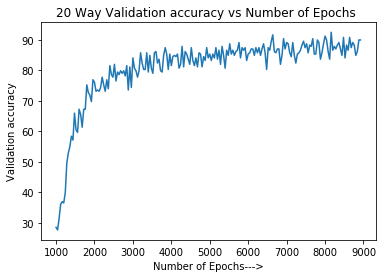

In [0]:
#with open('validation_result.pickle', "wb") as f:
#               pickle.dump(validation_accracy,f)

with open('validation_result.pickle',"rb") as f:
  vr=pickle.load(f)

x_lab=np.array([i for i in range(0,len(vr))])
x_ind=x_lab*1000
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_lab,vr)
ax.set_xticklabels(x_ind)
ax.set_ylabel('Validation accuracy')
ax.set_xlabel('Number of Epochs--->')
ax.set_title("20 Way Validation accuracy vs Number of Epochs ")
plt.show()

## Evaluation/Test on images_evaluation dataset

1. The Accuracy presented for evaluation is based on the model previously The Percentage accuracy for indentifying 659 classes varies by 0.5% with average at approximates 81.5% .Bascially the meaning of this accuracy result is that out of 659 classes 81% have been classfied properly.

[Comparison with the paper:](https://arxiv.org/abs/1711.06025)  It can be seen that the result for 1 shot 20 Way is around 97%. The model implemented here can be improved significantly in two ways increasing the augmented classes and batch size during training along with adjustments on learning rate to increase accuracy.
2. In code block 2 and 3 attempt to see the worst performing characters has been made. After running several  iterations it can be seen that around 20 to 24 classes/characters have lower accuracy (below 60%). Characters belonging to Kannada, Malayalam and Tibetian seems to be doing bad for several iterations based observation.
3. 5 to 35 way 1 shot classification testing was conducted on the model created and it can be seen that as N increases in N way classification. WIth 5 Way having max accuracy at around 93%

This trend is consistent with the pattern observed in Meta Learning models as claimed in the paper with 5 Way with 99% accuracy.

**Conclusion** 
The Relation Network model created in this work does a good job of classifying on a new untrained data with just One shot recognition. Further training of model with additional augmeted classes for training andadvanced optimization as described in [MAML](https://arxiv.org/pdf/1703.03400.pdf) can be used to further the accuracy of the existing model to achieve the accuracies described in the paper.





In [0]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
relational_net= model_from_json(loaded_model_json)
relational_net.load_weights("model.h5")

val_acc = loader.one_shot_evaluation(relational_net,iterations,N_way,"eval",verbose=True)

Evaluation 20 way for 659 unique characters
On an average 81.975721 Percent out of 659 unique characters are detected for 1 Shot 20 Way evaluation. 


In [0]:
class_val=loader.one_shot_classwise_evaluation(relational_net,iterations,N_way,"eval",verbose=True)

Class Wise Evaluation 20 way for 659 unique characters


In [0]:
(char_index,)=np.where(np.array(class_val)<60)
print("Number of characters with less than 60 % accuracy for the run on evaluation")
print(len(char_index))
with open('images_evaluation/val.pickle',"rb") as f:
  (eval_data,eval_catalogue)=pickle.load(f)

test_char_index={}
index=0
for alphabet in eval_catalogue.keys():
  test_char_index[alphabet]=(index,index+len(eval_catalogue[alphabet][0])-1)
  index+=len(eval_catalogue[alphabet][0])

for i in char_index:
  for alphabet in test_char_index.keys():
    if i>=test_char_index[alphabet][0] and i<=test_char_index[alphabet][1]:
      ci=i-test_char_index[alphabet][0]
      print('Character '+eval_catalogue[alphabet][0][ci]+' of alphabet '+ alphabet +' has detection accuracy of %f'%class_val[i])

Number of characters with less than 60 % accuracy
23
Character character12 of alphabet Glagolitic has detection accuracy of 56.000000
Character character35 of alphabet Oriya has detection accuracy of 56.000000
Character character24 of alphabet Tibetan has detection accuracy of 50.000000
Character character40 of alphabet Tibetan has detection accuracy of 50.000000
Character character25 of alphabet Atlantean has detection accuracy of 56.000000
Character character26 of alphabet Atlantean has detection accuracy of 54.000000
Character character22 of alphabet Syriac_(Serto) has detection accuracy of 48.000000
Character character12 of alphabet Syriac_(Serto) has detection accuracy of 58.000000
Character character04 of alphabet Syriac_(Serto) has detection accuracy of 56.000000
Character character24 of alphabet Tengwar has detection accuracy of 52.000000
Character character08 of alphabet Tengwar has detection accuracy of 52.000000
Character character02 of alphabet Tengwar has detection accurac

In [0]:
eval_accuracy=[]
for i in range(5,35,5):
  eval_accuracy.append(loader.one_shot_evaluation(relational_net,iterations,i,"eval",verbose=True))

Evaluation 5 way for 659 unique characters
On an average 93.547800 Percent out of 659 unique characters are detected for 1 Shot 5 Way evaluation. 
Evaluation 10 way for 659 unique characters
On an average 89.025797 Percent out of 659 unique characters are detected for 1 Shot 10 Way evaluation. 
Evaluation 15 way for 659 unique characters
On an average 84.968134 Percent out of 659 unique characters are detected for 1 Shot 15 Way evaluation. 
Evaluation 20 way for 659 unique characters
On an average 81.924127 Percent out of 659 unique characters are detected for 1 Shot 20 Way evaluation. 
Evaluation 25 way for 659 unique characters
On an average 79.326252 Percent out of 659 unique characters are detected for 1 Shot 25 Way evaluation. 
Evaluation 30 way for 659 unique characters
On an average 76.925645 Percent out of 659 unique characters are detected for 1 Shot 30 Way evaluation. 


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


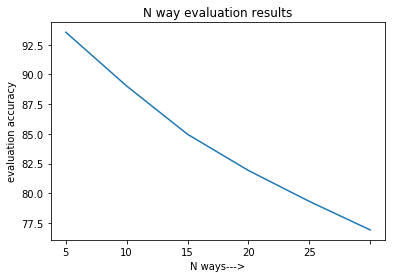

In [0]:
x_lab1=np.array([i for i in range(0,len(eval_accuracy))])
x_ind1=x_lab1*5
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_lab1,eval_accuracy)
ax.set_xticklabels(x_ind1)
ax.set_ylabel('evaluation accuracy')
ax.set_xlabel('N ways--->')
ax.set_title("N way evaluation results")
plt.show()